In [1]:
import librosa
import librosa.display
import scipy.io.wavfile
import sklearn
import tensorflow as tf
import numpy as np
from config import SEQ_LENGTH, FRAMERATE, CHUNK, FFT_SIZE
import matplotlib.pyplot as plt
import generate_wav_samples as gen
import os
import keras
import itertools
from config import MORSE_CHR
from tqdm import tqdm

from keras import backend as K
from keras import regularizers
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Input, Dense, Activation,TimeDistributed
from keras.layers import Reshape, Lambda, Dropout, Bidirectional
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU, SimpleRNN,LSTM
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import pickle
import Levenshtein
import string

Using TensorFlow backend.


In [2]:
OUTPUT_DIR = 'rnn_output'

In [4]:
class VizCallback(keras.callbacks.Callback):
    def __init__(self, run_name, test_func, X):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.X = X

    def show_edit_distance(self, num):
        print('edit distance: ', num)
        """
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func,
                                       word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j],
                                              word_batch['source_str'][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance:'
              '%.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))
        """

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        
        self.show_edit_distance(256)
                
        for i in range(5):
            labels = self.X[1][i:i+1]
            print('labels: ', labels_to_text([int(e) for e in labels[0]]))
        
        word_batch = self.X[0][:5]
        res = decode_batch(self.test_func, word_batch)
        print('result lens: ', len(res))
        for e in res[:5]:
            print(e)
            
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    bc = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    return bc
            
def cer(true, pred):
    t = ''.join(true).strip()
    p = ''.join(pred).strip()
    distance = Levenshtein.distance(t, p)
    return distance / len(t)

def labels_to_text(i):
    return [MORSE_CHR[e] for e in i]

def decode_batch2(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    print(np.argmax(out, axis = -1))
    return np.argmax(out, axis = -1)


def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    r = np.argmax(out, axis=-1)
    #print('r: ', r)
    
    res = []
    for a in r:
        sub_res = []
        for i, e in enumerate(a):
            #print(i, e)
            if i == 0:
                sub_res.append(e)
                continue
            if (e == a[i-1]):
                continue
            if (e == len(MORSE_CHR) - 1):
                continue
            sub_res.append(e)
            
        sub_res = [e for e in sub_res if e != len(MORSE_CHR) - 1]
        sub_res = labels_to_text(sub_res)
        res.append(sub_res)
            
    #[e if (i==0 or c != bc[i-1] and c!=3)]
    #print('res: ', res)
    return res



In [5]:
sample_len = SEQ_LENGTH

samples_count = 100000
sample_len = 40000
sr = 8000
dict_len = len(MORSE_CHR)
max_seq_len = 6
mel_count = 1
mel_len = 160

In [29]:
g = gen.seq_generator(SEQ_LENGTH, FRAMERATE, 1)

In [65]:
def get_wave_mel_features(wave):
    wave = wave.reshape(SEQ_LENGTH)
    wave = librosa.util.normalize(wave)
    mel = librosa.feature.melspectrogram(wave, sr=sr, n_fft=500, n_mels=mel_count,hop_length=250)
    #print(mel.shape)
    #librosa.display.specshow(mel)
    #plt.show()
    #raise Exception

    mel = mel.T
    mel = mel / np.max(mel)
    #mel = np.round(mel, decimals=4)
    return mel
        

def read_data(set_len):
    l = np.zeros([set_len, max_seq_len], dtype=np.int32)
    X = np.zeros([set_len,  mel_len, mel_count])
    input_length = np.zeros([set_len, 1], dtype=np.int32)
    label_length = np.zeros([set_len, 1], dtype=np.int32)

    i = 0
    for wave, label_indexes, labels, c in tqdm(g):        
        if len(labels) > max_seq_len:
            continue
        
        mel = get_wave_mel_features(wave)
        X[i, :, :] = mel
        
        l[i, :len(labels)] = labels
        input_length[i, :] = mel.shape[0]
        
        label_length[i, :1] = c
        
        i+=1
        if i == set_len:
            break
        
    return [X, l, input_length, label_length], l

In [ ]:
X, l = read_data(samples_count)

In [31]:
with open('dataset_100k.pickle', 'wb') as f:
    pickle.dump([X, l], f)

In [8]:
with open('dataset_100k.pickle', 'rb') as f:
    X, l = pickle.load(f)

In [9]:
(X[0].size * X[0].itemsize)

128000000

In [31]:
X_val, l_val = read_data(2000)



0it [00:00, ?it/s]

1it [00:00,  7.95it/s]

11it [00:00, 10.98it/s]

18it [00:00, 14.67it/s]

29it [00:00, 19.77it/s]

40it [00:00, 26.20it/s]

50it [00:00, 33.39it/s]

60it [00:00, 41.35it/s]

69it [00:00, 48.82it/s]

81it [00:00, 58.57it/s]

93it [00:01, 68.33it/s]

103it [00:01, 68.94it/s]

112it [00:01, 73.45it/s]

121it [00:01, 67.63it/s]

129it [00:01, 67.45it/s]

137it [00:01, 64.39it/s]

145it [00:01, 68.33it/s]

157it [00:01, 77.26it/s]

167it [00:02, 81.92it/s]

178it [00:02, 87.94it/s]

188it [00:02, 89.53it/s]

201it [00:02, 97.29it/s]

212it [00:02, 100.47it/s]

223it [00:02, 95.99it/s] 

233it [00:02, 84.71it/s]

245it [00:02, 92.88it/s]

255it [00:02, 94.49it/s]

265it [00:03, 90.87it/s]

275it [00:03, 88.31it/s]

285it [00:03, 89.23it/s]

295it [00:03, 89.16it/s]

305it [00:03, 92.05it/s]

315it [00:03, 91.99it/s]

329it [00:03, 100.15it/s]

341it [00:03, 104.50it/s]

352it [00:03, 103.68it/s]

363it [00:04, 105.31it/s]

374it [00:04, 105.90it/s]

385it [00:04, 94.61i

In [11]:
conv_filters = 128
kernel_size = 32
pool_size = 32
time_dense_size = 32
rnn_size = 64
minibatch_size = 32

dict_len

38

In [12]:
def get_model():
    input_shape = (mel_len, mel_count)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')

    inner = Conv1D(conv_filters, kernel_size, padding='same', 
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)

    mp = MaxPooling1D(pool_size=pool_size, name='max1', strides=1, padding='same')(inner)

    gru = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(mp)
    srnn = SimpleRNN(100, return_sequences=True, kernel_initializer='he_normal',)(mp)
    lstm = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm')(mp)
    #lstm2 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm)
    #lstm3 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm3')(lstm2)

    #dense2 = Dense(128, kernel_initializer='he_normal', name='dense2')(gru)

    #dpo = Dropout(0.01, name='do1')(gru)
    dense1 = Dense(dict_len, kernel_initializer='he_normal', name='dense1')(lstm)

    y_pred = Activation('softmax', name='softmax')(dense1)

    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[max_seq_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    print(y_pred, labels, input_length, label_length)

    loss_out = Lambda(
        ctc_lambda_func, output_shape=(1,),
        name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    rms = RMSprop(lr=0.01)
    sgd = SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5) #
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=rms)

    test_func = K.function([input_data], [y_pred])
    viz_cb = VizCallback('test', test_func, X_val)
    
    return model, viz_cb


In [19]:
model, viz_cb = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 160, 1)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 160, 128)          4224      
_________________________________________________________________
max1 (MaxPooling1D)          (None, 160, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 160, 64)           49408     
_________________________________________________________________
dense1 (Dense)               (None, 160, 38)           2470      
_________________________________________________________________
softmax (Activation)         (None, 160, 38)           0         
Total params: 56,102
Trainable params: 56,102
Non-trainable params: 0
_________________________________________________________________
Tensor

In [19]:
model.fit(X, l, validation_split=0.1, batch_size=5000, callbacks=[viz_cb], epochs=100)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 165s 2ms/step - loss: 18.4007 - val_loss: 18.1401
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 2/100
90000/90000 [==============================] - 175s 2ms/step - loss: 17.9919 - val_loss: 17.6969
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 3/100
90000/90000 [==============================] - 180s 2ms/step - loss: 17.6062 - val_loss: 17.2924
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', '

90000/90000 [==============================] - 145s 2ms/step - loss: 8.7774 - val_loss: 9.0411
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 25/100
90000/90000 [==============================] - 162s 2ms/step - loss: 8.4302 - val_loss: 8.4326
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 26/100
90000/90000 [==============================] - 149s 2ms/step - loss: 7.9301 - val_loss: 7.6587
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:

90000/90000 [==============================] - 132s 1ms/step - loss: 5.9866 - val_loss: 6.5408
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 48/100
90000/90000 [==============================] - 128s 1ms/step - loss: 5.9450 - val_loss: 5.9223
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 49/100
90000/90000 [==============================] - 128s 1ms/step - loss: 5.8426 - val_loss: 5.5721
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:

90000/90000 [==============================] - 128s 1ms/step - loss: 4.6275 - val_loss: 4.6549
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'C']
['3']
['A']
['A', 'Y']
['H']
Epoch 71/100
90000/90000 [==============================] - 128s 1ms/step - loss: 4.2641 - val_loss: 4.4090
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'C']
['3']
['W']
['A', 'Y']
['H', '3']
Epoch 72/100
90000/90000 [==============================] - 127s 1ms/step - loss: 4.4379 - val_loss: 3.9121
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S

90000/90000 [==============================] - 127s 1ms/step - loss: 2.1765 - val_loss: 3.0720
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'G', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'P', ' ']
Epoch 92/100
90000/90000 [==============================] - 127s 1ms/step - loss: 2.2346 - val_loss: 1.7626
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'G', 'S', ' ']
['A', 'T', 'T', 'V', 'Y', ' ']
['H', 'W', 'P', '3', ' ']
Epoch 93/100
90000/90000 [==============================] - 127s 1ms/step - loss: 2.2

In [20]:
model.fit(X, l, validation_split=0.1, batch_size=5000, callbacks=[viz_cb], epochs=100)

Train on 90000 samples, validate on 10000 samples
Epoch 1/100
90000/90000 [==============================] - 131s 1ms/step - loss: 1.4273 - val_loss: 1.2491
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 2/100
90000/90000 [==============================] - 130s 1ms/step - loss: 1.4643 - val_loss: 1.4567
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', 'S', ' ']
['A', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 3/1

edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 36/100
90000/90000 [==============================] - 126s 1ms/step - loss: 1.1788 - val_loss: 1.0844
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'A', 'G', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 37/100
90000/90000 [==============================] - 126s 1ms/step - loss: 0.9425 - val_loss: 0.8966
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' 

90000/90000 [==============================] - 126s 1ms/step - loss: 0.9579 - val_loss: 0.9747
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', ' ', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 54/100
90000/90000 [==============================] - 126s 1ms/step - loss: 1.3882 - val_loss: 2.4897
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', ' ', 'S', ' ']
['A', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 55/100
90000/90000 [=============================

90000/90000 [==============================] - 127s 1ms/step - loss: 0.9681 - val_loss: 0.7874
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', ' ', 'S', ' ']
['A', 'T', 'T', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 88/100
90000/90000 [==============================] - 127s 1ms/step - loss: 1.4562 - val_loss: 1.6897
edit distance:  256
labels:  ['M', 'P', 'C', ' ', ' ', ' ']
labels:  ['3', 'D', '2', 'D', ' ', ' ']
labels:  ['W', 'T', 'G', ' ', 'S', ' ']
labels:  ['A', 'U', 'T', 'V', 'Y', ' ']
labels:  ['H', 'W', 'L', 'P', '3', ' ']
result lens:  5
['M', 'P', 'C', ' ']
['3', 'D', '2', 'D', ' ']
['W', 'T', 'G', ' ', 'S', ' ']
['A', 'V', 'Y', ' ']
['H', 'W', 'L', 'P', '3', ' ']
Epoch 89/100
90000/90000 [=============================

In [14]:
model.fit(X, l, validation_split=0.1, batch_size=3000, callbacks=[viz_cb], epochs=100)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 90000 samples, validate on 10000 samples
Epoch 1/100
 6000/90000 [=>............................] - ETA: 2:17 - loss: 268.5818

116603it [31:00, 49.74it/s]

90000/90000 [==============================] - 93s 1ms/step - loss: 35.8501 - val_loss: 17.9041
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 2/100
90000/90000 [==============================] - 89s 987us/step - loss: 17.9174 - val_loss: 18.0633
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
[]
[]
[]
[]
[]
Epoch 3/100
90000/90000 [==============================] - 88s 983us/step - loss: 17.6883 - val_loss: 17.6202
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
la

90000/90000 [==============================] - 89s 985us/step - loss: 4.8514 - val_loss: 5.0092
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R']
['7']
['V', '0']
['V']
['M']
Epoch 25/100
90000/90000 [==============================] - 89s 985us/step - loss: 4.7339 - val_loss: 4.6033
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R']
['7']
['V', '0']
['V']
['M']
Epoch 26/100
90000/90000 [==============================] - 88s 983us/step - loss: 4.5963 - val_loss: 4.1181
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labe

90000/90000 [==============================] - 89s 984us/step - loss: 1.1297 - val_loss: 1.0597
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', ' ']
['V', '5', 'J', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 44/100
90000/90000 [==============================] - 89s 984us/step - loss: 1.2885 - val_loss: 1.0600
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', ' ']
['V', 'F', '2', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 45/100
90000/90000 [===========================

edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', ' ']
['V', 'F', '2', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 61/100
90000/90000 [==============================] - 89s 985us/step - loss: 1.6841 - val_loss: 1.2997
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', ' ']
['V', '0', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 62/100
90000/90000 [==============================] - 88s 983us/step - loss: 1.2697 - val_loss: 1.3068
edit distance:  256
labels:  ['R', 'Q', 'K', 

90000/90000 [==============================] - 89s 984us/step - loss: 2.1055 - val_loss: 2.8765
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'G', 'P', ' ']
['V', '8', 'K', ' ']
['V', 'U', ' ']
['M', 'J', 'L', ' ']
Epoch 79/100
90000/90000 [==============================] - 89s 984us/step - loss: 2.1514 - val_loss: 1.8077
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', '0', ' ']
['V', 'H', '2', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 80/100
90000/90000 [==============================] - 89s 988u

90000/90000 [==============================] - 89s 987us/step - loss: 2.1529 - val_loss: 2.1874
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'R', 'P', ' ']
['V', '8', 'K', '0', ' ']
['V', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 97/100
90000/90000 [==============================] - 89s 985us/step - loss: 1.8701 - val_loss: 2.1586
edit distance:  256
labels:  ['R', 'Q', 'K', 'L', ' ', ' ']
labels:  ['7', 'H', 'N', 'P', ' ', ' ']
labels:  ['V', '8', 'K', '0', ' ', ' ']
labels:  ['V', 'F', '2', 'M', 'U', ' ']
labels:  ['M', 'J', 'L', 'L', ' ', ' ']
result lens:  5
['R', 'Q', 'K', 'L', ' ']
['7', 'H', 'N', 'P', ' ']
['V', '8', 'K', '0', ' ']
['U', 'S', '2', 'M', 'U', ' ']
['M', 'J', 'L', 'L', ' ']
Epoch 98/100
90000/90000 [==============================] - 89s

In [68]:
best_model, _ = get_model()
best_model.load_weights('rnn_output/test/weights44.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 160, 1)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 160, 128)          4224      
_________________________________________________________________
max1 (MaxPooling1D)          (None, 160, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 160, 64)           49408     
_________________________________________________________________
dense1 (Dense)               (None, 160, 38)           2470      
_________________________________________________________________
softmax (Activation)         (None, 160, 38)           0         
Total params: 56,102
Trainable params: 56,102
Non-trainable params: 0
_________________________________________________________________
Tensor

In [ ]:
best_model.fit(X, l, validation_split=0.1, batch_size=5000, callbacks=[viz_cb], epochs=100)

In [21]:
get_all_layer_outputs = K.function([best_model.layers[0].input],
                                  [l.output for l in best_model.layers[1:] if l.name == 'softmax'])


In [69]:
decoded = decode_batch(get_all_layer_outputs, X_val[0])
decoded[:10]

[['V', 'B', '2', ' '],
 ['7', '3', 'D', 'K', ' '],
 ['H', 'G', 'W', 'S', 'Z', ' '],
 ['P', 'B', 'R', '0', ' '],
 ['Q', 'C', 'P', ' '],
 ['Z', 'X', 'X', 'T', ' '],
 ['1', 'G', ' '],
 ['B', ' ', '1', '5', ' '],
 ['A', 'N', 'O', ' '],
 ['R', 'V', '9', 'A', ' ']]

In [70]:
for i in l_val[:10]:
    print(labels_to_text(i))

['V', 'B', '2', ' ', ' ', ' ']
['7', '3', 'D', 'K', ' ', ' ']
['H', 'G', 'W', 'S', 'Z', ' ']
['P', 'B', 'R', '0', ' ', ' ']
['Q', 'E', 'C', 'P', ' ', ' ']
['Z', 'X', 'X', 'T', ' ', ' ']
['1', 'G', ' ', ' ', ' ', ' ']
['B', ' ', '1', '5', ' ', ' ']
['A', 'K', '8', 'N', 'O', ' ']
['R', 'V', '9', 'A', 'E', ' ']


In [71]:
cers = []
for i, t in enumerate(l_val):
    true = labels_to_text(t)
    pred = decoded[i]
    
    c = cer(true, pred)
    
    cers.append(c)
    
print(np.mean(cers))

0.05198333333333333


In [72]:
'/home/user/Downloads/websdr_recording_start_2019-06-15T21_33_16Z_7017.3kHz.wav'

wave, sr = librosa.core.load('/home/user/Dropbox/projs/MorseNet/generated/1.wav', sr=8000)
wave = wave[:39936]
mel = get_wave_mel_features(wave)


to_pred = np.zeros([1,  mel_len, mel_count])
to_pred[0,:,:] = mel

print(decode_batch(get_all_layer_outputs, X))


[['N', ' ', 'D', 'V', '7', ' ']]


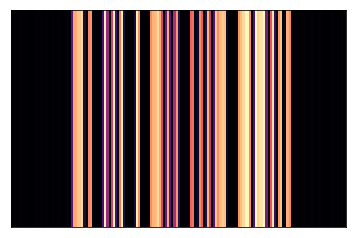

In [73]:
librosa.display.specshow(mel.T)
plt.show()
#raise Exception